# Connect CPU Runtime for this JupyterNotebook

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set all directories

In [ ]:
# Folder path for saving predict label, choose the image from this path for calculation
PREDICT_LABEL_DIR = "/content/drive/MyDrive/data/predict/predict_label/"


## Import Libraries and Modules

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import math
import pandas as pd
import csv

from matplotlib.patches import Circle

# [Edit] Choose the Image name to predict under PREDICT_IMAGE_DIR

In [ ]:
filename = "X2248-60000X-29.tif_Model_weights_-20.hdf5_threshold=0.8.png"

## Load and Preview the Image

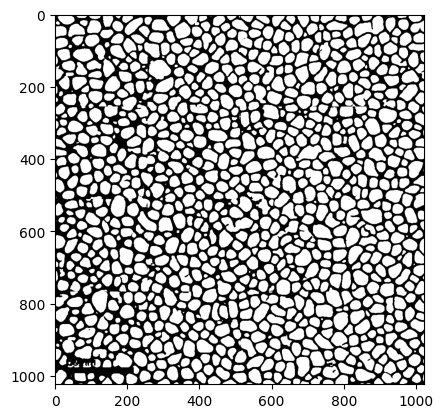

In [ ]:
image = cv2.imread(PREDICT_LABEL_DIR + filename)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

img = image_gray
img_copy = img.copy

plt.imshow(img, cmap='gray')



# [Edit] Setup Image Scale and Condition for Calculation

In [ ]:
nm = 100 #比例尺上的nm數
pixel_length = 287  #對應的pixel 數

In [ ]:
# 設定面積下限(/nm^2)。若無限制，令area_lower_limit = 0 或 = -math.inf
area_lower_limit = 50

# 設定面積上限(/nm^2)。若無限制，令area_lower_limit = math.inf (無限大)
area_upper_limit = 3500

# 設定真圓度下限。輸入[0,1]之間的值
circularity_lower_limit = 0.3


## Calculation Block

In [ ]:
areas_pixel, areas = [], []
diameters, perimeters = [], []
roundness = []
distances = []
contours, filtered_contours = [], []
centers, rads, centers_int = [], [], []

def distance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

def minDistance(coords):
    min_dists =[]
    for i in range(len(coords)):
        min_dist = float(math.inf)
        for j in range(len(coords)):
            if i != j:
                dist = distance(coords[i], coords[j]) * (nm/pixel_length)
                if dist < min_dist:
                    min_dist = dist * (nm/pixel_length)
        min_dists.append(min_dist)

    return min_dists



def plot_circles(img, centers, radii):

    # Plot the image
    plt.imshow(img)

    # Plot circles
    ax = plt.gca()
    for center, radius in zip(centers, radii):
        circle = Circle(center, radius, color='b', fill=False)
        ax.add_patch(circle)

    # Show the plot
    plt.axis('off')
    plt.show()

retv,thresh=cv2.threshold(img,0,1,1)
found_contours, hierarchy=cv2.findContours(thresh, cv2. RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for idx, contour in enumerate(found_contours):
    area_pixel = cv2.contourArea(contour)
    area = area_pixel * math.pow((nm/pixel_length), 2)
    if area_pixel != 0 and area !=0 :
        diameter = math.sqrt(4 * area / math.pi)
        perimeter = cv2.arcLength(contour, True)
        circularity = (4* math.pi * area_pixel) / math.pow(perimeter, 2)

        if (circularity >= circularity_lower_limit) and (area>=area_lower_limit) and (area <= area_upper_limit):

            (cx, cy), radius = cv2.minEnclosingCircle(contour)
            center = (cx, cy)
            center_int = (int(cx), int(cy))
            radius = int(radius)

            filtered_contours.append(contour)
            diameters.append(diameter)
            areas.append(area)
            roundness.append(circularity)
            contours.append(contour)

            centers.append(center)
            centers_int.append(center_int)
            rads.append(radius)


min_dists = minDistance(centers)

image1 = cv2.drawContours(image,contours,-1,(0,0,255),1,lineType=cv2.LINE_AA)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = image1


## Preview the Select Contours

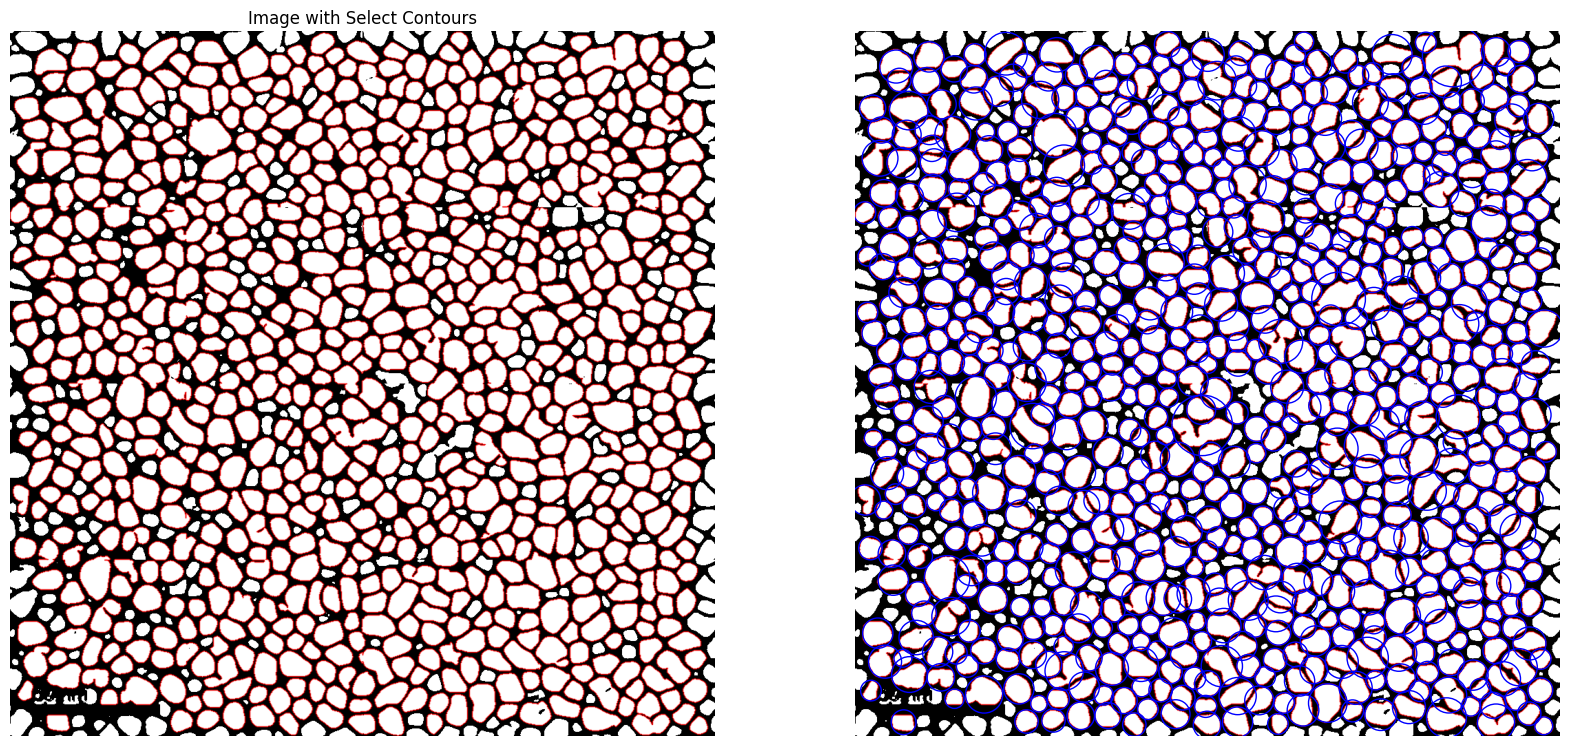

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(20, 15))

# setting values to rows and column variables
rows = 1
columns = 2

# Add subplot 1
fig.add_subplot(rows, columns, 1)
plt.imshow(image1)
plt.axis('off')
plt.title("Image with Select Contours")

# Add subplot 2
fig.add_subplot(rows, columns, 2)
plot_circles(image2, centers, rads)
#plt.title("Contours and Circumcircle")

# [Edit] Output the Calculation Result

In [ ]:
# Define the file name, including the file extension(副檔名)
output_filename = "calculation.csv"

# Save path for Calculation Result
SAVE_DIR = "/content/drive/MyDrive/data/predict/"

In [ ]:
# 將DataFrame寫入Excel文件中

list1 = [i+1 for i in range(len(contours))]

# 將列表轉換為DataFrame
df = pd.DataFrame({
    'SeqNo': list1,
    'Diameter (nm)':  diameters,
    'Area (nm^2)': areas,
    'Roundness': roundness,
    'Pitch distance': min_dists
})

# 寫入文件中
df.to_csv(SAVE_DIR+output_filename, index=False, header=True)

# After Finish, please "Disconnect and Delete Runtime" to Save Computing Credits.